In [1]:
# 顯存不夠用時用CPU跑
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 載入資料集
def load_gesture_data(directory):
    gesture_data = []
    labels = []
    
    categories = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            categories.append(category)
    
    category_files = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        files = []
        for file in os.listdir(category_path):
            if file.endswith('.npy'):
                files.append(file)
        category_files[category] = files
    
    max_files = 0
    for files in category_files.values():
        if len(files) > max_files:
            max_files = len(files)
    
    for i in range(max_files):
        for category in categories:
            files = category_files[category]
            
            if i < len(files):
                file_name = files[i]
                file_path = os.path.join(category, file_name)
                file_path_full = os.path.join(directory, file_path)
                print(f"Loading {file_path_full}")
                data = np.load(file_path_full)
                gesture_data.append(data)
                labels.append(category)  
    
    return np.array(gesture_data), labels


In [3]:
# 載入資料集
gesture_data_train, gesture_labels_train = load_gesture_data('train_data_seg/train')
gesture_data_test, gesture_labels_test = load_gesture_data('train_data_seg/test')
gesture_data_val, gesture_labels_val = load_gesture_data('train_data_seg/validation')

print("Original Gesture data train shape:", np.shape(gesture_data_train))
print("Original Gesture labels train shape:", np.shape(gesture_labels_train))

x_train_gesture = np.reshape(gesture_data_train, (-1, 2, 32, 32, 35))
x_test_gesture = np.reshape(gesture_data_test, (-1, 2, 32, 32, 35))
x_val_gesture = np.reshape(gesture_data_val, (-1, 2, 32, 32, 35))

x_train_gesture = np.transpose(x_train_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)
x_test_gesture = np.transpose(x_test_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)
x_val_gesture = np.transpose(x_val_gesture, [0, 4, 2, 3, 1]).reshape(-1, 32, 32, 2)


# 因為資料合併例如: (14260, 35, 32, 32, 2) -> (499100, 32, 32, 2) 因此label需要重複35遍
gesture_labels_train = np.repeat(gesture_labels_train, 35)
gesture_labels_test = np.repeat(gesture_labels_test, 35)
gesture_labels_val = np.repeat(gesture_labels_val, 35)

# 先編碼再獨熱編碼
label_encoder = LabelEncoder()
gesture_labels_train_encoded = label_encoder.fit_transform(gesture_labels_train)
gesture_labels_test_encoded = label_encoder.transform(gesture_labels_test)
gesture_labels_val_encoded = label_encoder.transform(gesture_labels_val)

gesture_labels_train_one_hot = to_categorical(gesture_labels_train_encoded)
gesture_labels_test_one_hot = to_categorical(gesture_labels_test_encoded)
gesture_labels_val_one_hot = to_categorical(gesture_labels_val_encoded)

gesture_labels_train_one_hot = np.reshape(gesture_labels_train_one_hot, (-1, 1, 8))
gesture_labels_test_one_hot = np.reshape(gesture_labels_test_one_hot, (-1, 1, 8))
gesture_labels_val_one_hot = np.reshape(gesture_labels_val_one_hot, (-1, 1, 8))

print("Reshaped Gesture data train shape:", x_train_gesture.shape)
print("Reshaped Gesture labels train shape:", gesture_labels_train_one_hot.shape)

Loading train_data_seg/train\fall_down\fall_down_segment_0.npy
Loading train_data_seg/train\patpat\patpat_segment_1029.npy
Loading train_data_seg/train\quickDown\quickDown_segment_1045.npy
Loading train_data_seg/train\quickUp\quickUp_segment_1053.npy
Loading train_data_seg/train\rollin\rollin_segment_1073.npy
Loading train_data_seg/train\rollout\rollout_segment_100.npy
Loading train_data_seg/train\swipLeft\swipLeft_segment_102.npy
Loading train_data_seg/train\swipRight\swipRight_segment_1000.npy
Loading train_data_seg/train\fall_down\fall_down_segment_1.npy
Loading train_data_seg/train\patpat\patpat_segment_1030.npy
Loading train_data_seg/train\quickDown\quickDown_segment_1046.npy
Loading train_data_seg/train\quickUp\quickUp_segment_1054.npy
Loading train_data_seg/train\rollin\rollin_segment_1074.npy
Loading train_data_seg/train\rollout\rollout_segment_101.npy
Loading train_data_seg/train\swipLeft\swipLeft_segment_103.npy
Loading train_data_seg/train\swipRight\swipRight_segment_1001.np

In [4]:
# 損失函數 L2Norm
def l2_loss(y_true, y_pred):
    diff = y_true - y_pred
    #print(f"Difference (diff): {diff.numpy()}")
    #print(f"y_true (label): {y_true}")
    #print(f"y_pred (label_pred): {y_pred}")
    loss = tf.reduce_mean(tf.square(diff))
    #print(f"loss: {loss}")
    return loss

In [4]:
# 載入原始模型
model = load_model('AI_Model\ourCNNmodel_forTL.h5')

In [5]:
# 加上全連接層
x = model.output

predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 online_cnn_fw/depthwise_con  (None, 15, 15, 2)        18        
 v2d_9/depthwise1 (Depthwise                                     
 Conv2D)                                                         
                                                                 
 online_cnn_fw/conv2d_9/Conv  (None, 15, 15, 32)       64        
 2D (Conv2D)                                                     
                                                                 
 online_cnn_fw/depthwise_con  (None, 7, 7, 32)         288       
 v2d_10/depthwise1 (Depthwis                                     
 eConv2D)                                                        
                                                             

In [5]:
# 依照需求載入訓練好的模型
model = load_model('CNN_35_epoch.h5', custom_objects={'l2_loss': l2_loss})

In [ ]:
model.summary()

In [4]:
model_LSTM = load_model('AI_Model\ori_LSTM.h5')

In [5]:
model_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35, 128)]         0         
                                                                 
 lstm (LSTM)                 (None, 35, 128)           131584    
                                                                 
 dense (Dense)               (None, 35, 8)             1032      
                                                                 
 softmax (Softmax)           (None, 35, 8)             0         
                                                                 
Total params: 132,616
Trainable params: 132,616
Non-trainable params: 0
_________________________________________________________________


In [7]:
# hook其中幾層 CNN
ModelExtract = Model(inputs=model.input, outputs=[model.layers[1].output,model.layers[2].output,model.layers[3].output ])

hook=[]
#id=[0, 1, 2, 3, 4, 5, 6 ,7 ,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
id=[0, 1, 2, 3, 4, 5, 6 ,7 ,8, 9]
#id=[8]
for i in range(len(id)):
  hook.append(model.layers[id[i]].output)
ModelExtract = Model(inputs=model.input, outputs=hook)


In [6]:
# hook其中幾層 LSTM
hook=[]
id=[0, 1, 2, 3]
for i in range(len(id)):
  hook.append(model_LSTM.layers[id[i]].output)
ModelExtract = Model(inputs=model_LSTM.input, outputs=hook)

In [7]:
# 查看hook哪幾層
ModelExtract.output

[<KerasTensor: shape=(None, 35, 128) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 35, 128) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 35, 8) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 35, 8) dtype=float32 (created by layer 'softmax')>]

In [8]:
predictions = ModelExtract.predict(x_test_gesture[:20000])
labels = gesture_labels_test_one_hot[:20000]

625/625 [==============================] - 2s 3ms/step


In [9]:
labels = gesture_labels_test_encoded[:20000]

In [8]:
CnnPredictions = np.load('predictions_test.npy')

In [9]:
CnnLabels_encoded = np.load('labels_test_encoded.npy')

In [10]:
# 將CNN預測結果切成35一段方便給LSTM預測
data_test = []

for i in range(1000000):
    if i + 35 > len(CnnPredictions):
        break
    data_test.append(CnnPredictions[i:i + 35, :])

print(np.shape(data_test))

(34231, 35, 128)


In [13]:
data_test = np.array(data_test[:20000])

In [14]:
LSTM_Predictions = ModelExtract.predict(data_test)

625/625 [==============================] - 11s 8ms/step


In [15]:
# labels for pca
labels = gesture_labels_test_encoded[:20000]

In [12]:
# 根據需求保存預測結果
np.save('predictions_test.npy', predictions)
np.save('labels_test.npy', labels)

In [14]:
np.save('labels_test_encoded.npy', labels)

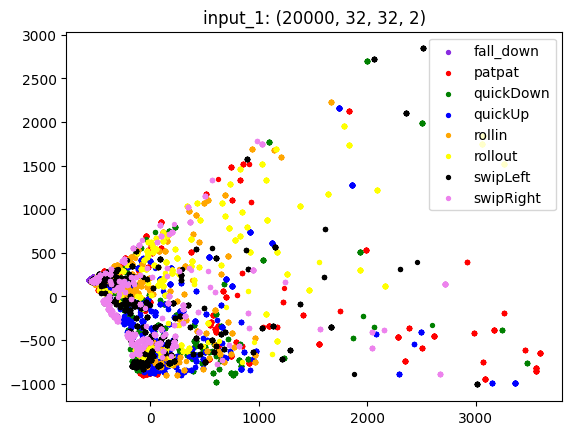

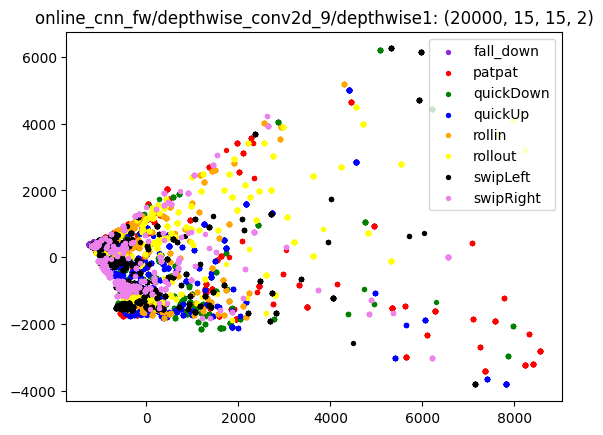

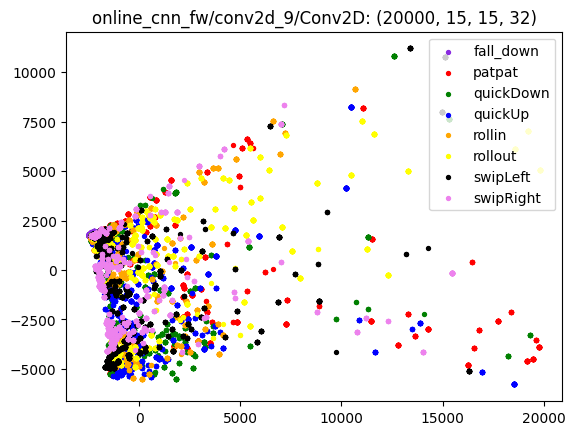

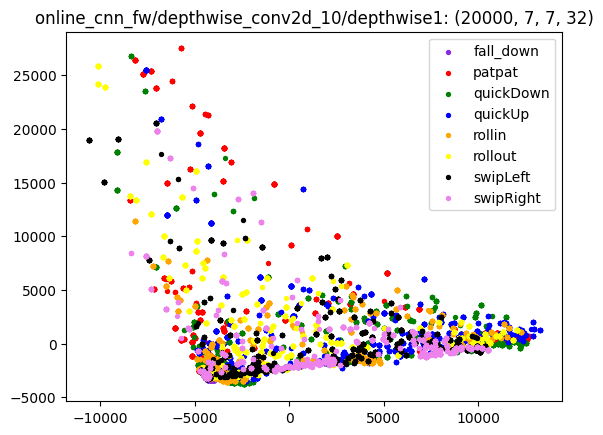

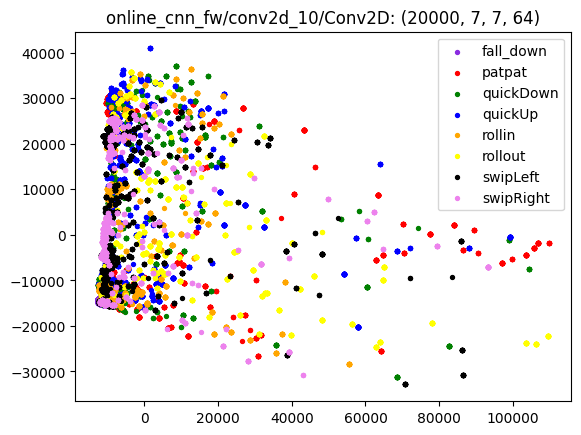

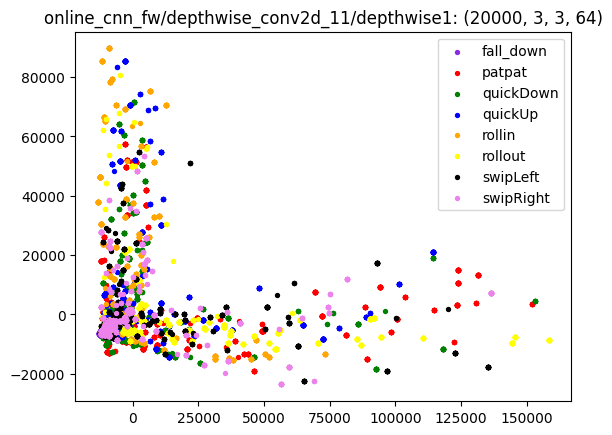

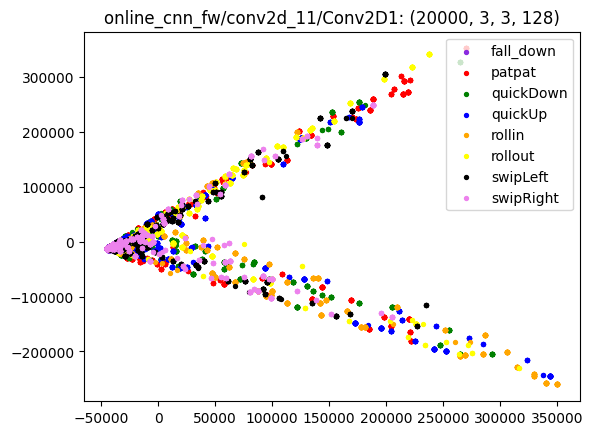

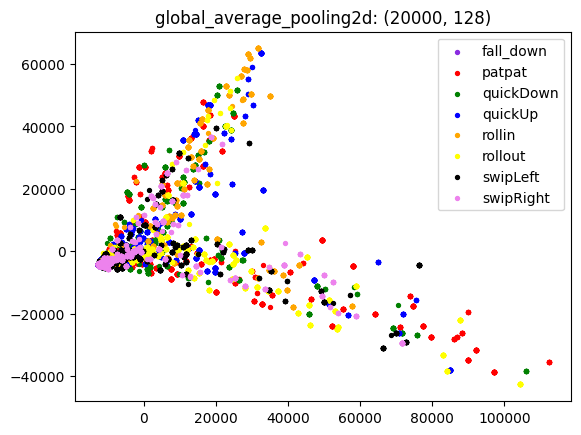

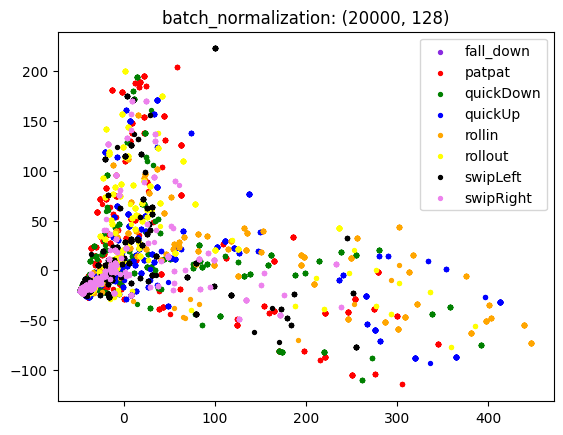

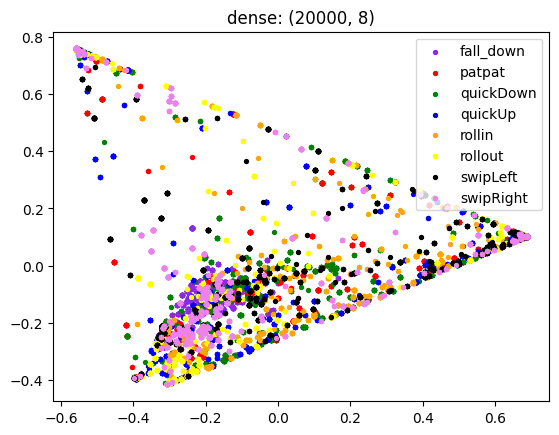

In [10]:
# PCA 
from sklearn import decomposition
PCA=[]

classes=['fall_down', 'patpat', 'quickDown', 'quickUp', 'rollin', 'rollout', 'swipLeft', 'swipRight']

label_to_color = {
    'patpat': [1, 0, 0, 1],         # Red
    'quickDown': [0, 0.5, 0, 1],    # Green
    'quickUp': [0, 0, 1, 1],        # Blue
    'rollin': [1, 0.65, 0, 1],      # Orange
    'rollout': [1, 1, 0, 1],        # Yellow
    'swipLeft': [0, 0, 0, 1],       # Black
    'swipRight': [0.93, 0.51, 0.93, 1],  # Violet
    'fall_down': [0.54, 0.17, 0.88, 1]   # Cyan
}

for i in range(len(predictions)):
    input=np.reshape(predictions[i],[len(predictions[i]),-1])
    pca=decomposition.PCA(n_components=2)
    pca.fit(input)
    PCA.append(pca)
    Dim2=PCA[-1].transform(input)
    plt.figure()
    plt.title(model.layers[id[i]].name+': '+f'{predictions[i].shape}')
    for cl in range(8):
        chos=Dim2[np.argwhere(labels==cl).reshape([-1])]
        color = label_to_color[classes[cl]]
        plt.scatter(chos[:, 0], chos[:, 1], label=classes[cl], marker='o', s=8, color=color)
    plt.legend(loc=1)

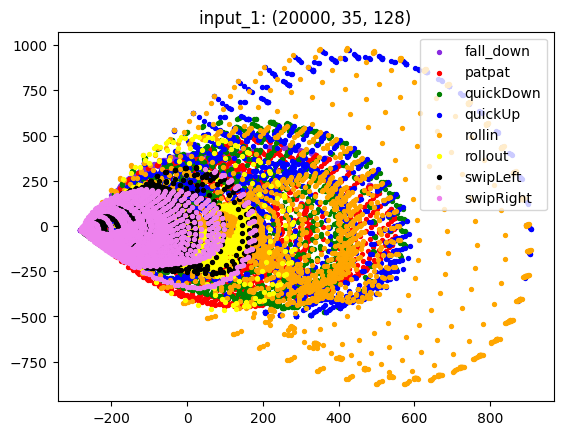

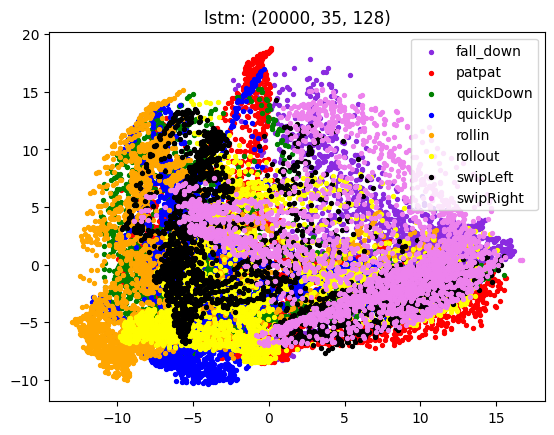

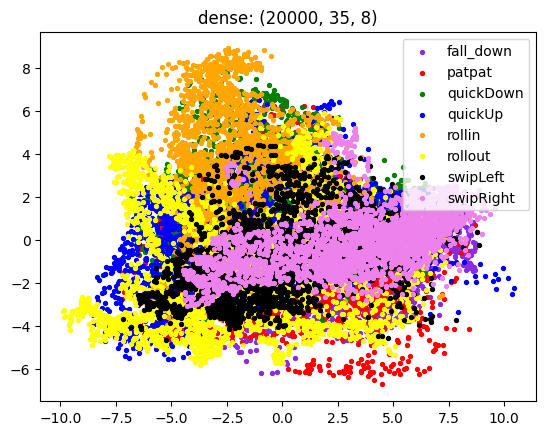

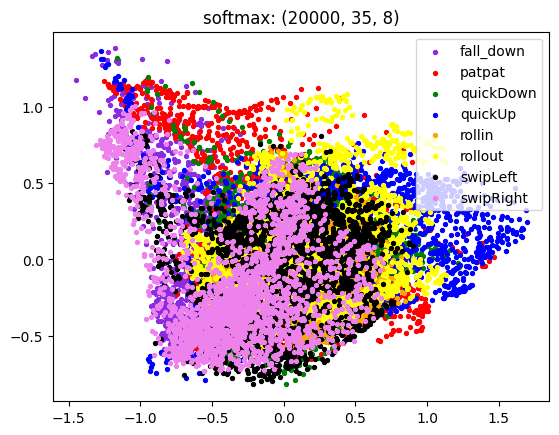

In [18]:
# PCA 
from sklearn import decomposition
PCA=[]

classes=['fall_down', 'patpat', 'quickDown', 'quickUp', 'rollin', 'rollout', 'swipLeft', 'swipRight']

label_to_color = {
    'patpat': [1, 0, 0, 1],         # Red
    'quickDown': [0, 0.5, 0, 1],    # Green
    'quickUp': [0, 0, 1, 1],        # Blue
    'rollin': [1, 0.65, 0, 1],      # Orange
    'rollout': [1, 1, 0, 1],        # Yellow
    'swipLeft': [0, 0, 0, 1],       # Black
    'swipRight': [0.93, 0.51, 0.93, 1],  # Violet
    'fall_down': [0.54, 0.17, 0.88, 1]   # Cyan
}

for i in range(len(LSTM_Predictions)):
    input=np.reshape(LSTM_Predictions[i],[len(LSTM_Predictions[i]),-1])
    pca=decomposition.PCA(n_components=2)
    pca.fit(input)
    PCA.append(pca)
    Dim2=PCA[-1].transform(input)
    plt.figure()
    plt.title(model_LSTM.layers[id[i]].name+': '+f'{LSTM_Predictions[i].shape}')
    for cl in range(8):
        chos=Dim2[np.argwhere(labels==cl).reshape([-1])]
        color = label_to_color[classes[cl]]
        plt.scatter(chos[:, 0], chos[:, 1], label=classes[cl], marker='o', s=8, color=color)
    plt.legend(loc=1)